# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Features](#Features)
- [Random Forest](#Random-Forest-Regression-Model)
    - [4-Seam RHP](#4-Seam-RHP)
    - [4-Seam LHP](#4-Seam-LHP)
    - [Cutter RHP](#Cutter-RHP)
    - [Cutter LHP](#Cutter-LHP)
    - [Sinker RHP](#Sinker-RHP)
    - [Sinker LHP](#Sinker-LHP)
    - [Slider RHP](#Slider-RHP)
    - [Slider LHP](#Slider-LHP)
    - [Curveball RHP](#Curveball-RHP)
    - [Curveball LHP](#Curveball-LHP)
    - [Changeup RHP](#Changeup-RHP)
    - [Changeup LHP](#Changeup-LHP)

# Imports

In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from matplotlib.patches import Rectangle

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/model-pitches-rv.csv', index_col = [0])
data.drop(columns = ['plate_x', 'release_pos_x'], inplace = True)
data.rename(columns = {'pfx_-x': 'pfx_x', 
                       'plate_-x': 'plate_x', 
                       'release_pos_-x': 'release_pos_x'}, 
            inplace = True)

pd.set_option('max_columns', None)
print(data.shape)
data.head()

(705396, 72)


,player_name,p_throws,pitch_type,velo,spin_rate,spin_axis,pfx_x,pfx_z,bauer_units,effective_speed,release_pos_x,release_pos_z,release_extension,release_pos_y,plate_x,plate_z,type,balls,strikes,pitch_count,delta_run_exp,stand,bb_type,description,events,hit_distance_sc,exit_velo,launch_angle,launch_speed_angle,woba_value,woba_denom,xba,xwoba,babip_value,iso_value,at_bat_number,pitch_number,inning,inning_topbot,home_score,away_score,post_home_score,post_away_score,on_1b,on_2b,on_3b,outs_when_up,arm_angle,slot,is_strike,is_ball,final_pitch_ab,out_to_end_inning,home_runs,away_runs,runs,re,re_change,re_end_state,re24,lin_weight_above_avg,lin_weight_above_outs,woba_scale,lin_weights_above_avg_scale,lin_weights_above_outs_scale,woba,wraa_change,count_re,bs_lin_weight,bs_lin_weight_scale,rv_above_avg,rv
0,"Smith, Will",L,FF,92.3,2330.0,148.0,-8.28,16.56,25.243770,92.8,-1.40,6.80,6.5,54.03,0.69,2.83,X,1,2,1-2,-0.073,R,ground_ball,hit_into_play,field_out,13.0,95.2,-13.0,2.0,0.0,1.0,0.174,0.158,0.0,0.0,61,4,9,0,5,0,5,0,0,0,0,2,36.0,overhead,1,0,1,1,0,0,0,0.098,-0.098,0.000,-0.098,-0.25,0.0,1.209,-0.302,0.0,0.223,-0.184,-0.282,-0.141,-0.170,-0.472,-0.170
1,"Smith, Will",L,SL,80.6,2254.0,315.0,9.24,5.76,27.965261,81.2,-1.60,6.64,6.4,54.15,0.71,2.62,S,1,1,1-1,-0.027,R,NaN,strike,NaN,108.0,75.3,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,3,9,0,5,0,5,0,0,0,0,2,45.8,3/4,1,0,0,0,0,0,0,0.098,0.000,0.098,0.000,NaN,NaN,1.209,0.000,0.0,0.293,-0.058,-0.058,-0.006,-0.007,-0.007,-0.007
2,"Smith, Will",L,CU,75.5,1940.0,328.0,7.80,-6.12,25.695364,75.2,-1.46,6.88,6.2,54.34,0.04,2.46,S,1,0,1-0,-0.020,R,NaN,strike,NaN,157.0,83.5,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,2,9,0,5,0,5,0,0,0,0,2,38.4,overhead,1,0,0,0,0,0,0,0.098,0.000,0.098,0.000,NaN,NaN,1.209,0.000,0.0,0.355,-0.051,-0.051,0.001,0.001,0.001,0.001
3,"Smith, Will",L,CU,75.0,2017.0,330.0,8.28,-8.28,26.893333,74.5,-1.53,6.83,5.9,54.61,-2.10,3.89,B,0,0,0-0,0.016,R,NaN,ball,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,1,9,0,5,0,5,0,0,0,0,2,38.4,overhead,0,1,0,0,0,0,0,0.098,0.000,0.098,0.000,NaN,NaN,1.209,0.000,0.0,0.314,0.034,0.034,-0.003,-0.004,-0.004,-0.004
4,"Smith, Will",L,FF,91.2,2281.0,143.0,-7.56,15.36,25.010965,90.9,-1.49,6.66,6.3,54.15,0.31,2.80,X,1,0,1-0,-0.189,L,ground_ball,hit_into_play,field_out,9.0,93.3,-18.0,2.0,0.0,1.0,0.100,0.090,0.0,0.0,60,2,9,0,5,0,5,0,0,0,0,1,36.0,overhead,1,0,1,0,0,0,0,0.254,-0.156,0.098,-0.156,-0.25,0.0,1.209,-0.302,0.0,0.355,-0.051,-0.207,0.001,0.001,-0.301,0.001


# Cleaning / EDA

### Features

**Independent Variables:** Velocity, Spin Rate, HB, VB, Release Side, Release Height, Arm Angle, Release Extension

**Dependent Variable:** Run Value

In [3]:
features = data[['player_name', 'p_throws', 'pitch_type', 'velo', 'spin_rate', 
                 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 'arm_angle',
                 'release_extension', 'rv']]

In [4]:
fastball = features[features['pitch_type'].isin(['FF', 'FC', 'SI'])]
breaking_ball = features[features['pitch_type'].isin(['SL', 'CU', 'KC'])]
offspeed = features[features['pitch_type'].isin(['CH', 'FS'])]
rhp = features.loc[features['p_throws'] == 'R']
lhp = features.loc[features['p_throws'] == 'L']
rhp_fastball = fastball.loc[fastball['p_throws'] == 'R']
lhp_fastball = fastball.loc[fastball['p_throws'] == 'L']
rhp_breaking_ball = breaking_ball.loc[breaking_ball['p_throws'] == 'R']
lhp_breaking_ball = breaking_ball.loc[breaking_ball['p_throws'] == 'L']
rhp_offspeed = offspeed.loc[offspeed['p_throws'] == 'R']
lhp_offspeed = offspeed.loc[offspeed['p_throws'] == 'L']
ff_r = rhp.loc[rhp['pitch_type'] == 'FF']
ff_l = lhp.loc[lhp['pitch_type'] == 'FF']
fc_r = rhp.loc[rhp['pitch_type'] == 'FC']
fc_l = lhp.loc[lhp['pitch_type'] == 'FC']
si_r = rhp.loc[rhp['pitch_type'] == 'SI']
si_l = lhp.loc[lhp['pitch_type'] == 'SI']
sl_r = rhp.loc[rhp['pitch_type'] == 'SL']
sl_l = lhp.loc[lhp['pitch_type'] == 'SL']
cu_r = rhp.loc[rhp['pitch_type'] == 'CU']
cu_l = lhp.loc[lhp['pitch_type'] == 'CU']
ch_r = rhp.loc[rhp['pitch_type'] == 'CH']
ch_l = lhp.loc[lhp['pitch_type'] == 'CH']

# Random Forest Regression Model

# 4-Seam RHP 

In [5]:
features_ff_r = ff_r.select_dtypes([np.number])
X = features_ff_r.drop(columns = ['rv'])
y = features_ff_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf_ff_r = RandomForestRegressor().fit(X_train, y_train)
pred_ff_r = rf_ff_r.predict(X_test)
pred = rf_ff_r.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_ff_r)), 3))
print('MSE:', round((metrics.mean_squared_error(y_test, pred_ff_r)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_ff_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_ff_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('MSE:', round((metrics.mean_squared_error(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.046
MSE: 0.098
RMSE: 0.313
MAE: 0.179 

R2 Score: 0.636
MSE: 0.035
RMSE: 0.188
MAE: 0.096


### RHP 4-Seam RV Table

In [6]:
ff_rhp = ff_r.copy()
ff_rhp['xRV'] = pred
ff_rhp['xRV'] = round(ff_rhp['xRV'], 3)
ff_rhp['n_pitches'] = [1 if x == 'FF' else 0 for x in ff_rhp['pitch_type']]

new_input = [[84.0, 2251.0, 4.7, 10.4, 1.40, 5.20, 45.0, 4.9]]
pred_new = rf_ff_r.predict(new_input)
columns = ['velo', 'spin_rate', 'HB', 'VB', 'release_pos_x', 
           'release_pos_z', 'arm_angle', 'release_extension']
new = pd.DataFrame(data = new_input, columns = columns)
new['xRV'] = pred_new
new.head()

,velo,spin_rate,HB,VB,release_pos_x,release_pos_z,arm_angle,release_extension,xRV
0,84.0,2251.0,4.7,10.4,1.4,5.2,45.0,4.9,0.31631


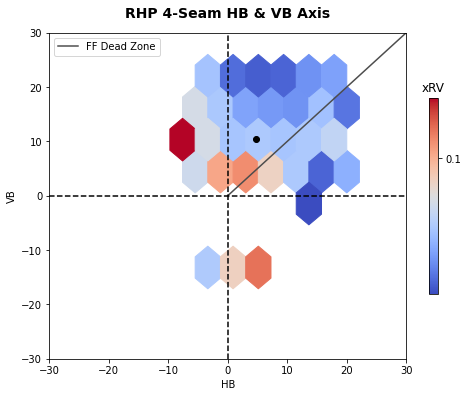

In [7]:
plt.figure(figsize = (8, 6))

ax = plt.hexbin(ff_rhp['pfx_x'], ff_rhp['pfx_z'], C = ff_rhp['xRV'], cmap = 'coolwarm', mincnt = 20, gridsize = 8)
plt.scatter(new['HB'], new['VB'], color = 'black')
plt.plot([0, 30], [0, 30], ls="-", c=".3", label = 'FF Dead Zone')
cb = plt.colorbar(ax, shrink = .6)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV') 
cb.set_ticks([0, 0, .10, .20], update_ticks = True)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--'), plt.legend()
plt.title('RHP 4-Seam HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

velo: avg. velo

pfx_x: avg. HB

pfx_z: avg. VB

arm_angle: in degrees (0-40: overhead, 41-60: 3/4, >= 61: sidearm

release_extension: avg. release extension in ft.

rv_above_outs: run value from pitch to pitch

xrv_above_outs: expected run value from pitch to pitch

RV: sum of all run values

xRV: sum of all expected run values

RV/100: sum or RV divided by n_pitches times 100

xRV/100: sum or xRV divided by n_pitches times 100

# 4-Seam LHP

In [8]:
features_ff_l = ff_l.select_dtypes([np.number])
X = features_ff_l.drop(columns = ['rv'])
y = features_ff_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf_ff_l = RandomForestRegressor().fit(X_train, y_train)
pred_ff_l = rf_ff_l.predict(X_test)
pred = rf_ff_l.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_ff_l)), 3))
print('MSE:', round((metrics.mean_squared_error(y_test, pred_ff_l)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_ff_l)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_ff_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('MSE:', round((metrics.mean_squared_error(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.053
MSE: 0.096
RMSE: 0.31
MAE: 0.178 

R2 Score: 0.637
MSE: 0.035
RMSE: 0.186
MAE: 0.095


### LHP 4-Seam RV Table

In [9]:
ff_lhp = ff_l.copy()
ff_lhp['xRV'] = pred
ff_lhp['xRV'] = round(ff_lhp['xRV'], 3)
ff_lhp['n_pitches'] = [1 if x == 'FF' else 0 for x in ff_lhp['pitch_type']]

new_input = [[84.0, 2251.0, -4.7, 10.4, -1.40, 5.20, 45.0, 4.9]]
pred_new = rf_ff_l.predict(new_input)
columns = ['velo', 'spin_rate', 'HB', 'VB', 'release_pos_x', 
           'release_pos_z', 'arm_angle', 'release_extension']
new = pd.DataFrame(data = new_input, columns = columns)
new['xRV'] = pred_new
new.head()

,velo,spin_rate,HB,VB,release_pos_x,release_pos_z,arm_angle,release_extension,xRV
0,84.0,2251.0,-4.7,10.4,-1.4,5.2,45.0,4.9,0.53725


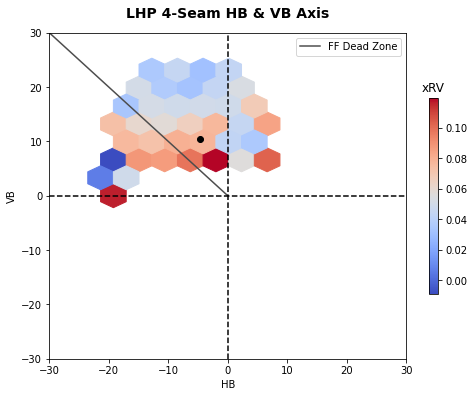

In [10]:
plt.figure(figsize = (8, 6))
ax = plt.hexbin(ff_lhp['pfx_x'], ff_lhp['pfx_z'], C = ff_lhp['xRV'], cmap = 'coolwarm', mincnt = 20, gridsize = 8)
plt.scatter(new['HB'], new['VB'], color = 'black')
plt.plot([0, -30], [0, 30], ls="-", c=".3", label = 'FF Dead Zone')
cb = plt.colorbar(ax, shrink = .6)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV') 
#cb.set_ticks([0, 0, .10, .20]) 
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--'), plt.legend()
plt.title('LHP 4-Seam HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

# Cutter RHP

In [11]:
features_fc_r = fc_r.select_dtypes([np.number])
X = features_fc_r.drop(columns = ['rv'])
y = features_fc_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf_fc_r = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_fc_r = rf_fc_r.predict(X_test)
pred = rf_fc_r.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_fc_r)), 3))
print('MSE:', round((metrics.mean_squared_error(y_test, pred_fc_r)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fc_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_fc_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('MSE:', round((metrics.mean_squared_error(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.052
MSE: 0.097
RMSE: 0.311
MAE: 0.173 

R2 Score: 0.622
MSE: 0.034
RMSE: 0.185
MAE: 0.091


### RHP Cutter RV Table

In [12]:
fc_rhp = fc_r.copy()
fc_rhp['xRV'] = pred
fc_rhp['xRV'] = round(fc_rhp['xRV'], 3)
fc_rhp['n_pitches'] = [1 if x == 'FF' else 0 for x in fc_rhp['pitch_type']]

new_input = [[80.8, 2044.0, 3.2, 12.2, 1.20, 5.40, 45.0, 4.9]]
pred_new = rf_fc_r.predict(new_input)
columns = ['velo', 'spin_rate', 'HB', 'VB', 'release_pos_x', 
           'release_pos_z', 'arm_angle', 'release_extension']
new = pd.DataFrame(data = new_input, columns = columns)
new['xRV'] = pred_new
new.head()

,velo,spin_rate,HB,VB,release_pos_x,release_pos_z,arm_angle,release_extension,xRV
0,80.8,2044.0,3.2,12.2,1.2,5.4,45.0,4.9,0.32829


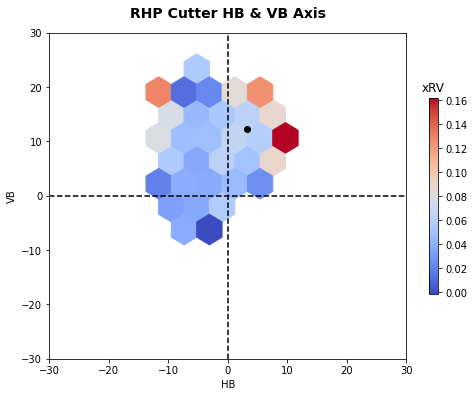

In [13]:
plt.figure(figsize = (8, 6))
ax = plt.hexbin(fc_rhp['pfx_x'], fc_rhp['pfx_z'], C = fc_rhp['xRV'], cmap = 'coolwarm', mincnt = 20, gridsize = 8)
plt.scatter(new['HB'], new['VB'], color = 'black')
cb = plt.colorbar(ax, shrink = .6)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV') 
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Cutter HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## Cutter LHP

In [14]:
features_fc_l = fc_l.select_dtypes([np.number])
X = features_fc_l.drop(columns = ['rv'])
y = features_fc_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf_fc_l = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_fc_l = rf_fc_l.predict(X_test)
pred = rf_fc_l.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_fc_l)), 3))
print('MSE:', round((metrics.mean_squared_error(y_test, pred_fc_l)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fc_l)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_fc_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('MSE:', round((metrics.mean_squared_error(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.04
MSE: 0.105
RMSE: 0.325
MAE: 0.182 

R2 Score: 0.62
MSE: 0.037
RMSE: 0.192
MAE: 0.096


### LHP Cutter RV Table

In [15]:
fc_lhp = fc_l.copy()
fc_lhp['xRV'] = pred
fc_lhp['xRV'] = round(fc_lhp['xRV'], 3)
fc_lhp['n_pitches'] = [1 if x == 'FF' else 0 for x in fc_lhp['pitch_type']]

new_input = [[80.8, 2044.0, -3.2, 12.2, -1.20, 5.40, 45.0, 4.9]]
pred_new = rf_fc_l.predict(new_input)
columns = ['velo', 'spin_rate', 'HB', 'VB', 'release_pos_x', 
           'release_pos_z', 'arm_angle', 'release_extension']
new = pd.DataFrame(data = new_input, columns = columns)
new['xRV'] = pred_new
new.head()

,velo,spin_rate,HB,VB,release_pos_x,release_pos_z,arm_angle,release_extension,xRV
0,80.8,2044.0,-3.2,12.2,-1.2,5.4,45.0,4.9,0.55859


### LHP Cutter HB & VB

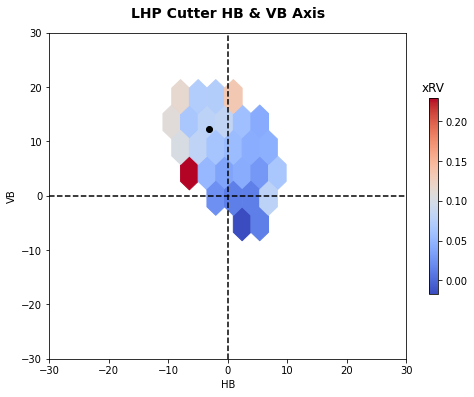

In [16]:
plt.figure(figsize = (8, 6))
ax = plt.hexbin(fc_lhp['pfx_x'], fc_lhp['pfx_z'], C = fc_lhp['xRV'], cmap = 'coolwarm', mincnt = 20, gridsize = 8)
plt.scatter(new['HB'], new['VB'], color = 'black')
cb = plt.colorbar(ax, shrink = .6)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV') 
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Cutter HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## Sinker RHP

In [17]:
features_si_r = si_r.select_dtypes([np.number])
X = features_si_r.drop(columns = ['rv'])
y = features_si_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf_si_r = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_si_r = rf_si_r.predict(X_test)
pred = rf_si_r.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_si_r)), 3))
print('MSE:', round((metrics.mean_squared_error(y_test, pred_si_r)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_si_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_si_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('MSE:', round((metrics.mean_squared_error(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.048
MSE: 0.104
RMSE: 0.323
MAE: 0.192 

R2 Score: 0.621
MSE: 0.037
RMSE: 0.191
MAE: 0.101


### RHP Sinker RV Table

In [18]:
si_rhp = si_r.copy()
si_rhp['xRV'] = pred
si_rhp['xRV'] = round(si_rhp['xRV'], 3)
si_rhp['n_pitches'] = [1 if x == 'FF' else 0 for x in si_rhp['pitch_type']]

new_input = [[80.8, 2044.0, 3.2, 12.2, 1.20, 5.40, 45.0, 4.9]]
pred_new = rf_si_r.predict(new_input)
columns = ['velo', 'spin_rate', 'HB', 'VB', 'release_pos_x', 
           'release_pos_z', 'arm_angle', 'release_extension']
new = pd.DataFrame(data = new_input, columns = columns)
new['xRV'] = pred_new
new.head()

,velo,spin_rate,HB,VB,release_pos_x,release_pos_z,arm_angle,release_extension,xRV
0,80.8,2044.0,3.2,12.2,1.2,5.4,45.0,4.9,0.48693


### RHP Sinker HB & VB

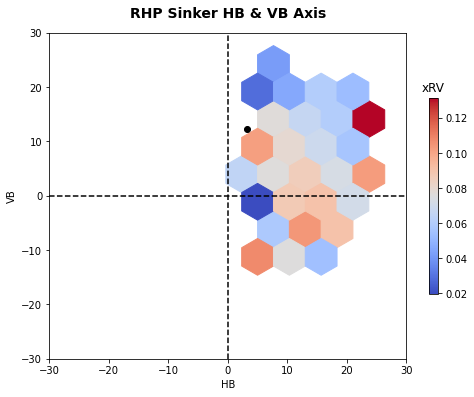

In [19]:
plt.figure(figsize = (8, 6))
ax = plt.hexbin(si_rhp['pfx_x'], si_rhp['pfx_z'], C = si_rhp['xRV'], cmap = 'coolwarm', mincnt = 20, gridsize = 8)
plt.scatter(new['HB'], new['VB'], color = 'black')
cb = plt.colorbar(ax, shrink = .6)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV') 
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Sinker HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## Sinker LHP

In [20]:
features_si_l = si_l.select_dtypes([np.number])
X = features_si_l.drop(columns = ['rv'])
y = features_si_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf_si_l = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_si_l = rf_si_l.predict(X_test)
pred = rf_si_l.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_si_l)), 3))
print('MSE:', round((metrics.mean_squared_error(y_test, pred_si_l)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_si_l)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_si_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('MSE:', round((metrics.mean_squared_error(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.057
MSE: 0.099
RMSE: 0.314
MAE: 0.185 

R2 Score: 0.627
MSE: 0.035
RMSE: 0.188
MAE: 0.099


### LHP Sinker RV Table

In [21]:
si_lhp = si_l.copy()
si_lhp['xRV'] = pred
si_lhp['xRV'] = round(si_lhp['xRV'], 3)
si_lhp['n_pitches'] = [1 if x == 'FF' else 0 for x in si_lhp['pitch_type']]

new_input = [[84.0, 2251.0, 4.7, 10.4, 1.40, 5.20, 45.0, 4.9]]
pred_new = rf_si_l.predict(new_input)
columns = ['velo', 'spin_rate', 'HB', 'VB', 'release_pos_x', 
           'release_pos_z', 'arm_angle', 'release_extension']
new = pd.DataFrame(data = new_input, columns = columns)
new['xRV'] = pred_new
new.head()

,velo,spin_rate,HB,VB,release_pos_x,release_pos_z,arm_angle,release_extension,xRV
0,84.0,2251.0,4.7,10.4,1.4,5.2,45.0,4.9,0.48665


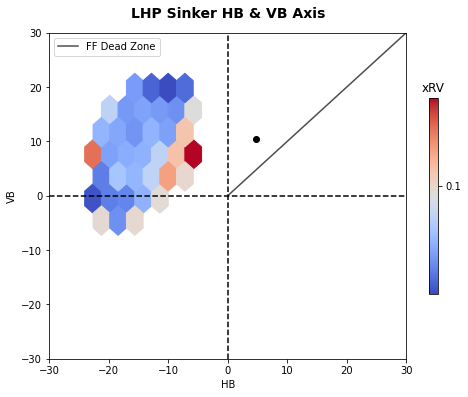

In [22]:
plt.figure(figsize = (8, 6))

ax = plt.hexbin(si_lhp['pfx_x'], si_lhp['pfx_z'], C = si_lhp['xRV'], cmap = 'coolwarm', mincnt = 20, gridsize = 8)
plt.scatter(new['HB'], new['VB'], color = 'black')
cb = plt.colorbar(ax, shrink = .6)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV') 
cb.set_ticks([0, 0, .10, .20], update_ticks = True)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--'), plt.legend()
plt.title('LHP Sinker HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## Slider RHP

In [23]:
features_sl_r = sl_r.select_dtypes([np.number])
X = features_sl_r.drop(columns = ['rv'])
y = features_sl_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf_si_r = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_sl_r = rf_si_r.predict(X_test)
pred = rf_si_r.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_sl_r)), 3))
print('MSE:', round((metrics.mean_squared_error(y_test, pred_sl_r)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_sl_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_sl_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('MSE:', round((metrics.mean_squared_error(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.038
MSE: 0.089
RMSE: 0.298
MAE: 0.159 

R2 Score: 0.622
MSE: 0.031
RMSE: 0.177
MAE: 0.085


### RHP Slider RV Table

In [24]:
sl_rhp = sl_r.copy()
sl_rhp['xRV'] = pred
sl_rhp['xRV'] = round(sl_rhp['xRV'], 3)
sl_rhp['n_pitches'] = [1 if x == 'FF' else 0 for x in sl_rhp['pitch_type']]

new_input = [[73.8, 2143.0, -0.5, -5.4, 1.40, 5.20, 45.0, 4.9]]
pred_new = rf_si_r.predict(new_input)
columns = ['velo', 'spin_rate', 'HB', 'VB', 'release_pos_x', 
           'release_pos_z', 'arm_angle', 'release_extension']
new = pd.DataFrame(data = new_input, columns = columns)
new['xRV'] = pred_new
new.head()

,velo,spin_rate,HB,VB,release_pos_x,release_pos_z,arm_angle,release_extension,xRV
0,73.8,2143.0,-0.5,-5.4,1.4,5.2,45.0,4.9,0.61323


No handles with labels found to put in legend.


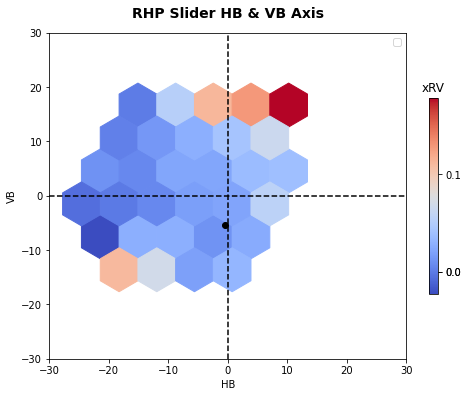

In [25]:
plt.figure(figsize = (8, 6))

ax = plt.hexbin(sl_rhp['pfx_x'], sl_rhp['pfx_z'], C = sl_rhp['xRV'], cmap = 'coolwarm', mincnt = 20, gridsize = 8)
plt.scatter(new['HB'], new['VB'], color = 'black')
cb = plt.colorbar(ax, shrink = .6)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV') 
cb.set_ticks([0, 0, .10, .20], update_ticks = True)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--'), plt.legend()
plt.title('RHP Slider HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## Slider LHP

In [26]:
features_sl_l = sl_l.select_dtypes([np.number])
X = features_sl_l.drop(columns = ['rv'])
y = features_sl_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf_sl_l = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_sl_l = rf_sl_l.predict(X_test)
pred = rf_sl_l.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_sl_l)), 3))
print('MSE:', round((metrics.mean_squared_error(y_test, pred_sl_l)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_sl_l)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_sl_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('MSE:', round((metrics.mean_squared_error(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.054
MSE: 0.087
RMSE: 0.294
MAE: 0.161 

R2 Score: 0.623
MSE: 0.031
RMSE: 0.175
MAE: 0.085


### LHP Slider RV Table

In [27]:
sl_lhp = sl_l.copy()
sl_lhp['xRV'] = pred
sl_lhp['xRV'] = round(sl_lhp['xRV'], 3)
sl_lhp['n_pitches'] = [1 if x == 'FF' else 0 for x in sl_lhp['pitch_type']]

new_input = [[73.8, 2143.0, 0.5, -5.4, -1.40, 5.20, 45.0, 4.9]]
pred_new = rf_sl_l.predict(new_input)
columns = ['velo', 'spin_rate', 'HB', 'VB', 'release_pos_x', 
           'release_pos_z', 'arm_angle', 'release_extension']
new = pd.DataFrame(data = new_input, columns = columns)
new['xRV'] = pred_new
new.head()

,velo,spin_rate,HB,VB,release_pos_x,release_pos_z,arm_angle,release_extension,xRV
0,73.8,2143.0,0.5,-5.4,-1.4,5.2,45.0,4.9,0.19349


No handles with labels found to put in legend.


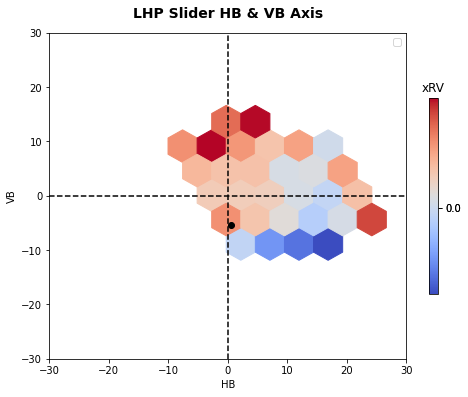

In [28]:
plt.figure(figsize = (8, 6))

ax = plt.hexbin(sl_lhp['pfx_x'], sl_lhp['pfx_z'], C = sl_lhp['xRV'], cmap = 'coolwarm', mincnt = 20, gridsize = 8)
plt.scatter(new['HB'], new['VB'], color = 'black')
cb = plt.colorbar(ax, shrink = .6)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV') 
cb.set_ticks([0, 0, .10, .20], update_ticks = True)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--'), plt.legend()
plt.title('LHP Slider HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## Curveball RHP

In [29]:
features_cu_r = cu_r.select_dtypes([np.number])
X = features_cu_r.drop(columns = ['rv'])
y = features_cu_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf_cu_r = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_cu_r = rf_cu_r.predict(X_test)
pred = rf_cu_r.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_cu_r)), 3))
print('MSE:', round((metrics.mean_squared_error(y_test, pred_cu_r)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_cu_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_cu_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('MSE:', round((metrics.mean_squared_error(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.053
MSE: 0.078
RMSE: 0.279
MAE: 0.143 

R2 Score: 0.612
MSE: 0.027
RMSE: 0.164
MAE: 0.075


### RHP Curveball RV Table

In [30]:
cu_rhp = cu_r.copy()
cu_rhp['xRV'] = pred
cu_rhp['xRV'] = round(cu_rhp['xRV'], 3)
cu_rhp['n_pitches'] = [1 if x == 'FF' else 0 for x in cu_rhp['pitch_type']]

new_input = [[67.6, 1696.0, -4.9, -18.1, 1.40, 5.20, 45.0, 4.9]]
pred_new = rf_cu_r.predict(new_input)
columns = ['velo', 'spin_rate', 'HB', 'VB', 'release_pos_x', 
           'release_pos_z', 'arm_angle', 'release_extension']
new = pd.DataFrame(data = new_input, columns = columns)
new['xRV'] = pred_new
new.head()

,velo,spin_rate,HB,VB,release_pos_x,release_pos_z,arm_angle,release_extension,xRV
0,67.6,1696.0,-4.9,-18.1,1.4,5.2,45.0,4.9,0.34722


No handles with labels found to put in legend.


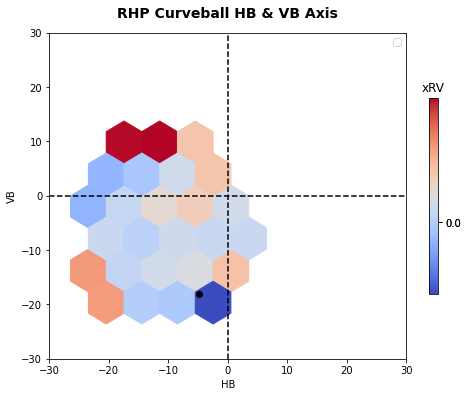

In [31]:
plt.figure(figsize = (8, 6))

ax = plt.hexbin(cu_rhp['pfx_x'], cu_rhp['pfx_z'], C = cu_rhp['xRV'], cmap = 'coolwarm', mincnt = 20, gridsize = 8)
plt.scatter(new['HB'], new['VB'], color = 'black')
cb = plt.colorbar(ax, shrink = .6)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV') 
cb.set_ticks([0, 0, .10, .20], update_ticks = True)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--'), plt.legend()
plt.title('RHP Curveball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## Curveball LHP

In [32]:
features_cu_l = cu_l.select_dtypes([np.number])
X = features_cu_l.drop(columns = ['rv'])
y = features_cu_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf_cu_l = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_cu_l = rf_cu_l.predict(X_test)
pred = rf_cu_l.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_cu_l)), 3))
print('MSE:', round((metrics.mean_squared_error(y_test, pred_cu_l)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_cu_l)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_cu_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('MSE:', round((metrics.mean_squared_error(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.075
MSE: 0.074
RMSE: 0.271
MAE: 0.144 

R2 Score: 0.629
MSE: 0.026
RMSE: 0.163
MAE: 0.078


### LHP Curveball RV Table

In [33]:
cu_lhp = cu_l.copy()
cu_lhp['xRV'] = pred
cu_lhp['xRV'] = round(cu_lhp['xRV'], 3)
cu_lhp['n_pitches'] = [1 if x == 'FF' else 0 for x in cu_lhp['pitch_type']]

new_input = [[67.6, 1696.0, 4.9, -18.1, -1.40, 5.20, 45.0, 4.9], 
             [69.2, 2020.0, 8.7, -4.6, -1.40, 5.20, 45.0, 4.9]]
pred_new = rf_cu_l.predict(new_input)
columns = ['velo', 'spin_rate', 'HB', 'VB', 'release_pos_x', 
           'release_pos_z', 'arm_angle', 'release_extension']
new = pd.DataFrame(data = new_input, columns = columns)
new['xRV'] = pred_new
new.head()

,velo,spin_rate,HB,VB,release_pos_x,release_pos_z,arm_angle,release_extension,xRV
0,67.6,1696.0,4.9,-18.1,-1.4,5.2,45.0,4.9,0.50107
1,69.2,2020.0,8.7,-4.6,-1.4,5.2,45.0,4.9,0.11365


No handles with labels found to put in legend.


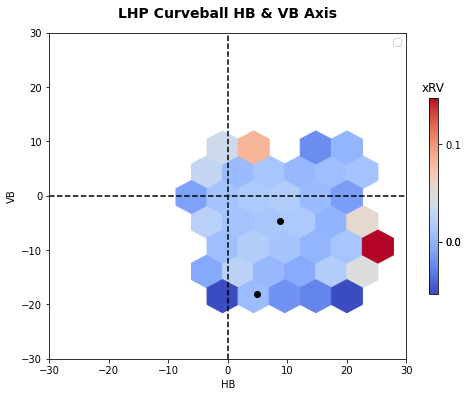

In [34]:
plt.figure(figsize = (8, 6))

ax = plt.hexbin(cu_lhp['pfx_x'], cu_lhp['pfx_z'], C = cu_lhp['xRV'], cmap = 'coolwarm', mincnt = 20, gridsize = 8)
plt.scatter(new['HB'], new['VB'], color = 'black')
cb = plt.colorbar(ax, shrink = .6)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV') 
cb.set_ticks([0, 0, .10, .20], update_ticks = True)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--'), plt.legend()
plt.title('LHP Curveball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## Changeup RHP

In [35]:
features_ch_r = ch_r.select_dtypes([np.number])
X = features_ch_r.drop(columns = ['rv'])
y = features_ch_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf_ch_r = RandomForestRegressor().fit(X_train, y_train)
pred_ch_r = rf_ch_r.predict(X_test)
pred = rf_ch_r.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_ch_r)), 3))
print('MSE:', round((metrics.mean_squared_error(y_test, pred_ch_r)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_ch_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_ch_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('MSE:', round((metrics.mean_squared_error(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.059
MSE: 0.093
RMSE: 0.304
MAE: 0.17 

R2 Score: 0.629
MSE: 0.033
RMSE: 0.182
MAE: 0.091


### RHP Changeup RV Table

In [36]:
ch_rhp = ch_r.copy()
ch_rhp['xRV'] = pred
ch_rhp['xRV'] = round(ch_rhp['xRV'], 3)
ch_rhp['n_pitches'] = [1 if x == 'FF' else 0 for x in ch_rhp['pitch_type']]

new_input = [[75.0, 1434.0, 3.2, 12.8, 1.30, 5.30, 45.0, 4.9]]
pred_new = rf_ch_r.predict(new_input)
columns = ['velo', 'spin_rate', 'HB', 'VB', 'release_pos_x', 
           'release_pos_z', 'arm_angle', 'release_extension']
new = pd.DataFrame(data = new_input, columns = columns)
new['xRV'] = pred_new
new.head()

,velo,spin_rate,HB,VB,release_pos_x,release_pos_z,arm_angle,release_extension,xRV
0,75.0,1434.0,3.2,12.8,1.3,5.3,45.0,4.9,0.34446


No handles with labels found to put in legend.


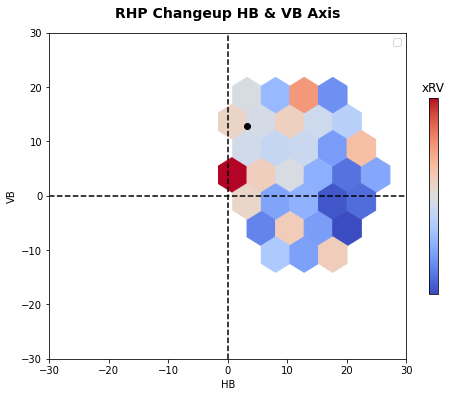

In [37]:
plt.figure(figsize = (8, 6))

ax = plt.hexbin(ch_rhp['pfx_x'], ch_rhp['pfx_z'], C = ch_rhp['xRV'], cmap = 'coolwarm', mincnt = 20, gridsize = 8)
plt.scatter(new['HB'], new['VB'], color = 'black')
cb = plt.colorbar(ax, shrink = .6)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV') 
cb.set_ticks([0, 0, .10, .20], update_ticks = True)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--'), plt.legend()
plt.title('RHP Changeup HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## Changeup LHP

In [38]:
features_ch_l = ch_l.select_dtypes([np.number])
X = features_ch_l.drop(columns = ['rv'])
y = features_ch_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf_ch_l = RandomForestRegressor().fit(X_train, y_train)
pred_ch_l = rf_ch_l.predict(X_test)
pred = rf_ch_l.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_ch_l)), 3))
print('MSE:', round((metrics.mean_squared_error(y_test, pred_ch_l)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_ch_l)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_ch_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('MSE:', round((metrics.mean_squared_error(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.048
MSE: 0.1
RMSE: 0.317
MAE: 0.179 

R2 Score: 0.618
MSE: 0.035
RMSE: 0.188
MAE: 0.094


### LHP Changeup RV Table

In [39]:
ch_lhp = ch_l.copy()
ch_lhp['xRV'] = pred
ch_lhp['xRV'] = round(ch_lhp['xRV'], 3)
ch_lhp['n_pitches'] = [1 if x == 'FF' else 0 for x in ch_lhp['pitch_type']]

new_input = [[75.0, 1434.0, -3.2, 12.8, -1.30, 5.30, 45.0, 4.9]]
pred_new = rf_ch_l.predict(new_input)
columns = ['velo', 'spin_rate', 'HB', 'VB', 'release_pos_x', 
           'release_pos_z', 'arm_angle', 'release_extension']
new = pd.DataFrame(data = new_input, columns = columns)
new['xRV'] = pred_new
new.head()

,velo,spin_rate,HB,VB,release_pos_x,release_pos_z,arm_angle,release_extension,xRV
0,75.0,1434.0,-3.2,12.8,-1.3,5.3,45.0,4.9,0.7185


No handles with labels found to put in legend.


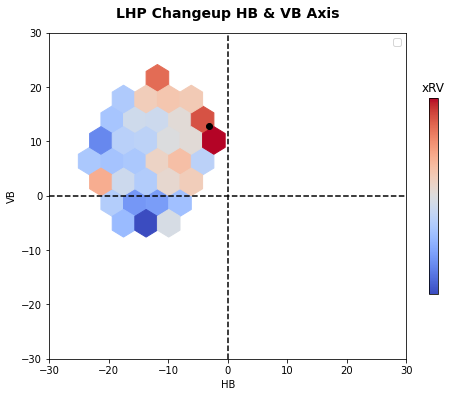

In [40]:
plt.figure(figsize = (8, 6))

ax = plt.hexbin(ch_lhp['pfx_x'], ch_lhp['pfx_z'], C = ch_lhp['xRV'], cmap = 'coolwarm', mincnt = 20, gridsize = 8)
plt.scatter(new['HB'], new['VB'], color = 'black')
cb = plt.colorbar(ax, shrink = .6)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV') 
cb.set_ticks([0, 0, .10, .20], update_ticks = True)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--'), plt.legend()
plt.title('LHP Changeup HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

# Grouped Pitches

## Fastball RHP

#### 4-Seam, Cutter, Sinker

In [41]:
features_fastball_r = rhp_fastball.select_dtypes([np.number])
X = features_fastball_r.drop(columns = ['rv'])
y = features_fastball_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf_fastball_r = RandomForestRegressor().fit(X_train, y_train)
pred_fastball_r = rf_fastball_r.predict(X_test)
pred = rf_fastball_r.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_fastball_r)), 3))
print('MSE:', round((metrics.mean_squared_error(y_test, pred_fastball_r)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fastball_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_fastball_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('MSE:', round((metrics.mean_squared_error(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: -0.038
MSE: 0.101
RMSE: 0.318
MAE: 0.182 

R2 Score: 0.628
MSE: 0.036
RMSE: 0.189
MAE: 0.096


### RHP Fastball RV Table

In [43]:
fastball_rhp = rhp_fastball.copy()
fastball_rhp['xRV'] = pred
fastball_rhp['xRV'] = round(ff_rhp['xRV'], 3)
#fastball_rhp['n_pitches'] = [1 if x == 'FF' else 0 for x in fastball_rhp['pitch_type']]

new_input = [[84.0, 2251.0, 4.7, 10.4, 1.40, 5.20, 45.0, 4.9]]
pred_new = rf_fastball_r.predict(new_input)
columns = ['velo', 'spin_rate', 'HB', 'VB', 'release_pos_x', 
           'release_pos_z', 'arm_angle', 'release_extension']
new = pd.DataFrame(data = new_input, columns = columns)
new['xRV'] = pred_new
new.head()

,velo,spin_rate,HB,VB,release_pos_x,release_pos_z,arm_angle,release_extension,xRV
0,84.0,2251.0,4.7,10.4,1.4,5.2,45.0,4.9,0.37319


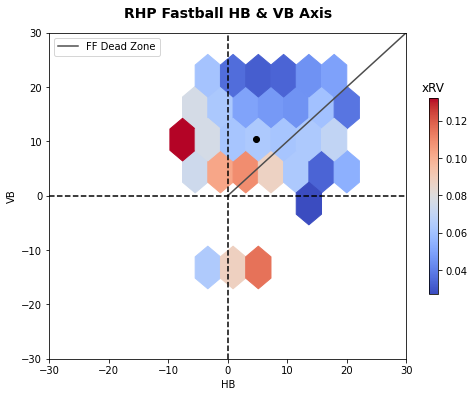

In [45]:
plt.figure(figsize = (8, 6))

ax = plt.hexbin(fastball_rhp['pfx_x'], fastball_rhp['pfx_z'], C = fastball_rhp['xRV'], 
                cmap = 'coolwarm', mincnt = 20, gridsize = 8)
plt.scatter(new['HB'], new['VB'], color = 'black')
plt.plot([0, 30], [0, 30], ls="-", c=".3", label = 'FF Dead Zone')
cb = plt.colorbar(ax, shrink = .6)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV') 
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--'), plt.legend()
plt.title('RHP Fastball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## Fastball LHP

#### 4-Seam, Cutter, Sinker

In [46]:
features_fastball_l = lhp_fastball.select_dtypes([np.number])
X = features_fastball_l.drop(columns = ['rv'])
y = features_fastball_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf_fastball_l = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_fastball_l = rf_fastball_l.predict(X_test)
pred = rf_fastball_l.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_fastball_l)), 3))
print('MSE:', round((metrics.mean_squared_error(y_test, pred_fastball_l)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fastball_l)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_fastball_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('MSE:', round((metrics.mean_squared_error(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: -0.05
MSE: 0.1
RMSE: 0.317
MAE: 0.181 

R2 Score: 0.627
MSE: 0.036
RMSE: 0.189
MAE: 0.097


### LHP Fastball RV Table

In [47]:
fastball_lhp = lhp_fastball.copy()
fastball_lhp['xRV'] = pred
fastball_lhp['xRV'] = round(fastball_lhp['xRV'], 3)
#fastball_lhp['n_pitches'] = [1 if x == 'FF' else 0 for x in fastball_lhp['pitch_type']]

new_input = [[84.0, 2251.0, 4.7, 10.4, 1.40, 5.20, 45.0, 4.9]]
pred_new = rf_fastball_l.predict(new_input)
columns = ['velo', 'spin_rate', 'HB', 'VB', 'release_pos_x', 
           'release_pos_z', 'arm_angle', 'release_extension']
new = pd.DataFrame(data = new_input, columns = columns)
new['xRV'] = pred_new
new.head()

,velo,spin_rate,HB,VB,release_pos_x,release_pos_z,arm_angle,release_extension,xRV
0,84.0,2251.0,4.7,10.4,1.4,5.2,45.0,4.9,0.75328


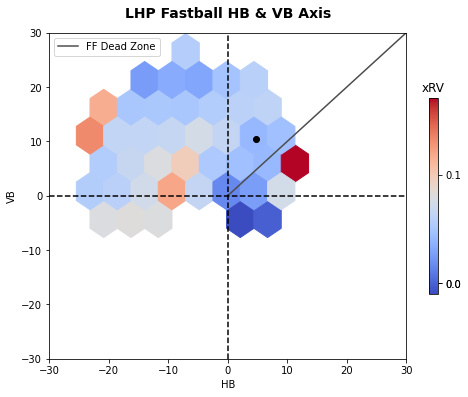

In [48]:
plt.figure(figsize = (8, 6))

ax = plt.hexbin(fastball_lhp['pfx_x'], fastball_lhp['pfx_z'], C = fastball_lhp['xRV'], 
                cmap = 'coolwarm', mincnt = 20, gridsize = 8)
plt.scatter(new['HB'], new['VB'], color = 'black')
plt.plot([0, 30], [0, 30], ls="-", c=".3", label = 'FF Dead Zone')
cb = plt.colorbar(ax, shrink = .6)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV') 
cb.set_ticks([0, 0, .10, .20], update_ticks = True)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--'), plt.legend()
plt.title('LHP Fastball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## Breaking Ball RHP

#### Slider, Curveball, Knuckle Curve

In [49]:
features_bb_r = rhp_breaking_ball.select_dtypes([np.number])
X = features_bb_r.drop(columns = ['rv'])
y = features_bb_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf_bb_r = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_bb_r = rf_bb_r.predict(X_test)
pred = rf_bb_r.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_bb_r)), 3))
print('MSE:', round((metrics.mean_squared_error(y_test, pred_bb_r)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_bb_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_bb_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('MSE:', round((metrics.mean_squared_error(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.042
MSE: 0.081
RMSE: 0.284
MAE: 0.151 

R2 Score: 0.632
MSE: 0.029
RMSE: 0.17
MAE: 0.081


### RHP Breaking Ball RV Table

In [51]:
bb_rhp = rhp_breaking_ball.copy()
bb_rhp['xRV'] = pred
bb_rhp['xRV'] = round(bb_rhp['xRV'], 3)
bb_rhp['n_pitches'] = [1 if x == 'FF' else 0 for x in bb_rhp['pitch_type']]

new_input = [[73.8, 2143.0, -0.5, -5.4, 1.40, 5.20, 45.0, 4.9], 
             [67.6, 1696.0, -4.9, -18.1, 1.40, 5.20, 45.0, 4.9], 
             [69.2, 2020.0, -8.7, -4.6, 1.40, 5.20, 45.0, 4.9]]
pred_new = rf_bb_r.predict(new_input)
columns = ['velo', 'spin_rate', 'HB', 'VB', 'release_pos_x', 
           'release_pos_z', 'arm_angle', 'release_extension']
new = pd.DataFrame(data = new_input, columns = columns)
new['xRV'] = pred_new
new.head()

,velo,spin_rate,HB,VB,release_pos_x,release_pos_z,arm_angle,release_extension,xRV
0,73.8,2143.0,-0.5,-5.4,1.4,5.2,45.0,4.9,0.46364
1,67.6,1696.0,-4.9,-18.1,1.4,5.2,45.0,4.9,0.53185
2,69.2,2020.0,-8.7,-4.6,1.4,5.2,45.0,4.9,0.33700


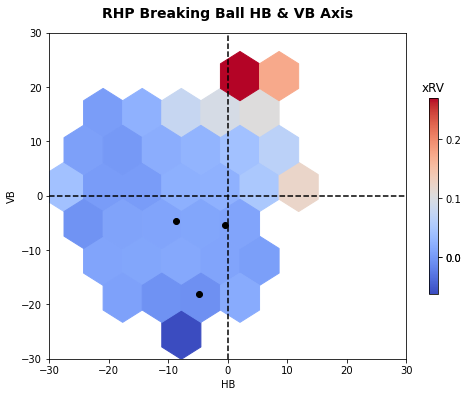

In [53]:
plt.figure(figsize = (8, 6))

ax = plt.hexbin(bb_rhp['pfx_x'], bb_rhp['pfx_z'], C = bb_rhp['xRV'], cmap = 'coolwarm', mincnt = 20, gridsize = 8)
plt.scatter(new['HB'], new['VB'], color = 'black')
cb = plt.colorbar(ax, shrink = .6)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV') 
cb.set_ticks([0, 0, .10, .20], update_ticks = True)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Breaking Ball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## Breaking Ball LHP

#### Slider, Curveball, Knuckle Curve

In [54]:
features_bb_l = lhp_breaking_ball.select_dtypes([np.number])
X = features_bb_l.drop(columns = ['rv'])
y = features_bb_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf_bb_l = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_bb_l = rf_bb_l.predict(X_test)
pred = rf_bb_l.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_bb_l)), 3))
print('MSE:', round((metrics.mean_squared_error(y_test, pred_bb_l)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_bb_l)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_bb_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('MSE:', round((metrics.mean_squared_error(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.042
MSE: 0.082
RMSE: 0.287
MAE: 0.152 

R2 Score: 0.626
MSE: 0.029
RMSE: 0.17
MAE: 0.081


### LHP Breaking Ball RV Table

In [55]:
bb_lhp = lhp_breaking_ball.copy()
bb_lhp['xRV'] = pred
bb_lhp['xRV'] = round(bb_lhp['xRV'], 3)
bb_lhp['n_pitches'] = [1 if x == 'FF' else 0 for x in bb_lhp['pitch_type']]

new_input = [[73.8, 2143.0, 0.5, -5.4, -1.40, 5.20, 45.0, 4.9], 
             [67.6, 1696.0, 4.9, -18.1, -1.40, 5.20, 45.0, 4.9], 
             [69.2, 2020.0, 8.7, -4.6, -1.40, 5.20, 45.0, 4.9]]
pred_new = rf_bb_l.predict(new_input)
columns = ['velo', 'spin_rate', 'HB', 'VB', 'release_pos_x', 
           'release_pos_z', 'arm_angle', 'release_extension']
new = pd.DataFrame(data = new_input, columns = columns)
new['xRV'] = pred_new
new.head()

,velo,spin_rate,HB,VB,release_pos_x,release_pos_z,arm_angle,release_extension,xRV
0,73.8,2143.0,0.5,-5.4,-1.4,5.2,45.0,4.9,0.16590
1,67.6,1696.0,4.9,-18.1,-1.4,5.2,45.0,4.9,0.20228
2,69.2,2020.0,8.7,-4.6,-1.4,5.2,45.0,4.9,0.24779


No handles with labels found to put in legend.


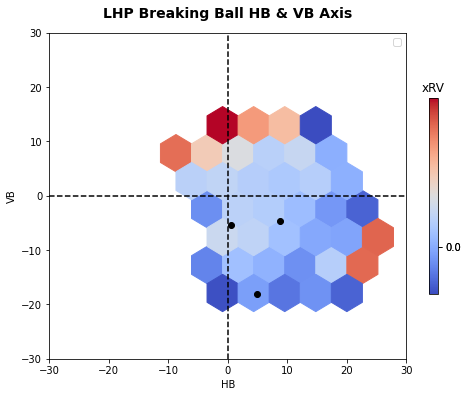

In [56]:
plt.figure(figsize = (8, 6))

ax = plt.hexbin(bb_lhp['pfx_x'], bb_lhp['pfx_z'], C = bb_lhp['xRV'], cmap = 'coolwarm', mincnt = 20, gridsize = 8)
plt.scatter(new['HB'], new['VB'], color = 'black')
cb = plt.colorbar(ax, shrink = .6)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV') 
cb.set_ticks([0, 0, .10, .20], update_ticks = True)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--'), plt.legend()
plt.title('LHP Breaking Ball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## Off-Speed RHP

#### Changeup, Splitter

In [57]:
features_os_r = rhp_offspeed.select_dtypes([np.number])
X = features_os_r.drop(columns = ['rv'])
y = features_os_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf_os_r = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_os_r = rf_os_r.predict(X_test)
pred = rf_os_r.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_os_r)), 3))
print('MSE:', round((metrics.mean_squared_error(y_test, pred_os_r)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_os_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_os_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('MSE:', round((metrics.mean_squared_error(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: -0.053
MSE: 0.09
RMSE: 0.301
MAE: 0.166 

R2 Score: 0.629
MSE: 0.032
RMSE: 0.18
MAE: 0.089


### RHP Off-Speed RV Table

In [58]:
os_rhp = rhp_offspeed.copy()
os_rhp['xRV'] = pred
os_rhp['xRV'] = round(os_rhp['xRV'], 3)
os_rhp['n_pitches'] = [1 if x == 'FF' else 0 for x in os_rhp['pitch_type']]

new_input = [[75.0, 1434.0, 3.2, 12.8, 1.30, 5.30, 45.0, 4.9]]
pred_new = rf_os_r.predict(new_input)
columns = ['velo', 'spin_rate', 'HB', 'VB', 'release_pos_x', 
           'release_pos_z', 'arm_angle', 'release_extension']
new = pd.DataFrame(data = new_input, columns = columns)
new['xRV'] = pred_new
new.head()

,velo,spin_rate,HB,VB,release_pos_x,release_pos_z,arm_angle,release_extension,xRV
0,75.0,1434.0,3.2,12.8,1.3,5.3,45.0,4.9,0.30272


No handles with labels found to put in legend.


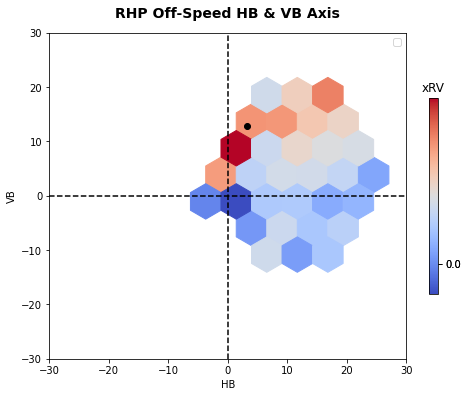

In [59]:
plt.figure(figsize = (8, 6))

ax = plt.hexbin(os_rhp['pfx_x'], os_rhp['pfx_z'], C = os_rhp['xRV'], cmap = 'coolwarm', mincnt = 20, gridsize = 8)
plt.scatter(new['HB'], new['VB'], color = 'black')
cb = plt.colorbar(ax, shrink = .6)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV') 
cb.set_ticks([0, 0, .10, .20], update_ticks = True)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--'), plt.legend()
plt.title('RHP Off-Speed HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## Off-speed LHP

#### Changeup, Splitter

In [60]:
features_os_l = lhp_offspeed.select_dtypes([np.number])
X = features_os_l.drop(columns = ['rv'])
y = features_os_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf_os_l = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_os_l = rf_os_l.predict(X_test)
pred = rf_os_l.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_os_l)), 3))
print('MSE:', round((metrics.mean_squared_error(y_test, pred_os_l)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_os_l)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_os_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('MSE:', round((metrics.mean_squared_error(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: -0.037
MSE: 0.099
RMSE: 0.315
MAE: 0.175 

R2 Score: 0.62
MSE: 0.035
RMSE: 0.187
MAE: 0.093


### LHP Off-Speed RV Table

In [61]:
os_lhp = lhp_offspeed.copy()
os_lhp['xRV'] = pred
os_lhp['xRV'] = round(os_lhp['xRV'], 3)
os_lhp['n_pitches'] = [1 if x == 'FF' else 0 for x in os_lhp['pitch_type']]

new_input = [[75.0, 1434.0, -3.2, 12.8, -1.30, 5.30, 45.0, 4.9]]
pred_new = rf_os_l.predict(new_input)
columns = ['velo', 'spin_rate', 'HB', 'VB', 'release_pos_x', 
           'release_pos_z', 'arm_angle', 'release_extension']
new = pd.DataFrame(data = new_input, columns = columns)
new['xRV'] = pred_new
new.head()

,velo,spin_rate,HB,VB,release_pos_x,release_pos_z,arm_angle,release_extension,xRV
0,75.0,1434.0,-3.2,12.8,-1.3,5.3,45.0,4.9,0.63331


No handles with labels found to put in legend.


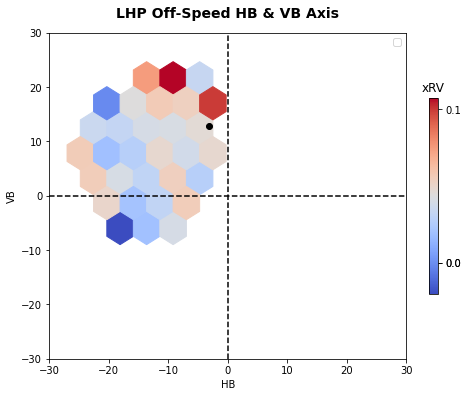

In [62]:
plt.figure(figsize = (8, 6))

ax = plt.hexbin(os_lhp['pfx_x'], os_lhp['pfx_z'], C = os_lhp['xRV'], cmap = 'coolwarm', mincnt = 20, gridsize = 8)
plt.scatter(new['HB'], new['VB'], color = 'black')
cb = plt.colorbar(ax, shrink = .6)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV') 
cb.set_ticks([0, 0, .10, .20], update_ticks = True)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Off-Speed HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);